In [189]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
%matplotlib inline
import warnings;warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as spstats
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [8]:
target = '标签'
uid = '申请编号'
uid_h = '历史申请编号'

In [19]:
############## D3

d3= pd.read_csv('./data/train_History_Application.csv', header=0)
d3.shape
d3.head()

d4= pd.read_csv('./data/train_History_Payment.csv', header=0)
d4.shape
d4.head()

(647963, 32)

,历史申请编号,申请编号,贷款类型,贷款年金,申请额度,信用额度,首付金额,商品价格,申请周内日,申请时点,...,商品类别,组合类型,产品类型,获客渠道,销售区域,行业,贷款期数,收益级别,产品组合,首付时间
0,1040733,173562,0,4444.0,106931,119633.0,NaN,106931.0,5,5,...,27,2,2,3,0,10,44.0,2,7.0,292204.0
1,450011,173562,0,3831.0,79211,90188.0,NaN,79211.0,7,4,...,27,2,2,0,4,10,44.0,3,7.0,292204.0
2,698695,173562,A,861.0,8327,4180.0,4367.0,8327.0,5,5,...,2,3,0,7,84,4,7.0,1,10.0,292204.0
3,924081,173562,A,1183.0,12568,12568.0,11.0,12568.0,7,4,...,7,3,0,7,83,5,14.0,3,12.0,292204.0
4,907875,173562,1,1990.0,11,39611.0,NaN,NaN,6,6,...,27,0,2,3,0,10,0.0,0,1.0,-560.0


(5257909, 8)

,历史申请编号,申请编号,分期付款日期,有支付行为的分期付款,分期付款应支付时间,分期付款实际支付时间,本期贷款金额,本期还款金额
0,225186,81363,2,8,-934,-939.0,1233.0,1233.0
1,877876,81363,2,26,-426,-431.0,2000.0,2000.0
2,225186,81363,2,3,-1030,-1035.0,1233.0,1233.0
3,518289,81363,2,3,-182,-184.0,1308.0,1308.0
4,877876,81363,2,13,-690,-695.0,2000.0,2000.0


In [27]:
####### D1 ~ D4 Exploration

# D3
d3_info = {}

d3_info['desc'] = d3.drop([uid, uid_h], axis=1).describe().T
d3_info['desc'].to_csv(f'./ana/0_cols_desc3.csv')

# D4
d4_info = {}

d4_info['desc'] = d4.drop([uid, uid_h], axis=1).describe().T
d4_info['desc'].to_csv(f'./ana/0_cols_desc4.csv')

In [43]:
d3['合同状态'].value_counts()

0    402301
1    119560
2    115686
3     10416
Name: 合同状态, dtype: int64

In [29]:
d4.loc[d4[uid]==173562, :].T.to_csv(f'./ana/9_t4_case1.csv')

In [49]:
################  Load Features

X = pd.read_csv('./tmp/train_d12_d3_dum.csv', header=0, index_col=0)
# pd.DataFrame(features.columns.values).to_csv('./ana/1_feature_cols.csv')
X.shape

y = pd.read_csv('./data/train_label.csv', header=0, index_col=0)
len(y)

# Merge
xy = pd.merge(X, y, on=uid, how='inner')
xy.drop(uid, axis=1, inplace=True)
xy.shape

# X, y
X = xy.copy()
X.shape
y = X.pop(target)
X.shape
y.shape

140000

(140000, 391)

In [72]:
############# correlations

# correlations = xy.corr()

# correlations.apply(abs).to_csv('./ana/0_correlations_abs.csv')
# correlations.to_csv('./ana/0_correlations.csv')

# Abs
correlations_target_abs = correlations.loc[correlations.index != target, target].apply(abs).sort_values(ascending=False)
correlations_target_abs.to_csv('./ana/0_correlations_target.csv')
correlations_target_abs.describe()

# fscore_corr = pd.DataFrame(correlations_target_abs)
# fscore_corr.columns = ['corr']
# fscore_corr.head()
f = pd.DataFrame(correlations_target_abs.index, columns=['feature'])
score_corr = pd.DataFrame(correlations_target_abs.values, columns=['corr'])
fscore_corr = pd.concat([f, score_corr], axis=1).sort_values(by='corr', ascending=False).reset_index(drop=True)
fscore_corr.head()


# # >=0.01
# features_top = {}
# features_top['corr'] = correlations_target_abs[correlations_target_abs>=0.01]
# features_top['corr'].count()

count    390.000000
mean       0.021778
std        0.021535
min        0.000004
25%        0.004890
50%        0.015055
75%        0.031533
max        0.131480
Name: 标签, dtype: float64

233

In [81]:
# For kfold
n_folds = 5

# RF
param_fixed_rf = {
    'n_jobs' : 1,
    'oob_score' : True,
    'random_state':123,
    'verbose':0
}

# XGB
param_fixed_xgb = {
    'n_jobs' : 1,
    'eval_metric': 'auc',
    'seed' : 123,
    'silent' : 1,
    'verbose_eval':0
}

# LGB
param_fixed_lgb = {
    'n_jobs' : 1,
    'metric' : 'auc',
    'bagging_seed':123,
    'feature_fraction_seed':123,
    'verbose_eval' : 0
}

In [148]:
############# RF importance

# RF
# best_params_load = np.load('./model/base_rf.npy', allow_pickle=True).item()
# model_params = {**best_params_load, **param_fixed_rf}
# RF = RandomForestClassifier(**model_params)

# # Train
# RF.fit(X, y)

# Importance
f = pd.DataFrame(X.columns, columns=['feature'])
score = pd.DataFrame(RF.feature_importances_, columns=['rf'])
fscore_rf = pd.concat([f, score], axis=1).sort_values(by='rf', ascending=False).reset_index(drop=True)
fscore_rf.head()

,feature,rf
0,外部评分,0.074344
1,工作日期距申请日期天数,0.063480
2,出生日期距申请日期天数,0.040367
3,合同状态_2mean,0.026247
4,教育程度_1,0.025231


In [248]:
############# XGB importance

# XGB
best_params_load = np.load('./model/base_xgb.npy', allow_pickle=True).item()
model_params = {**best_params_load, **param_fixed_xgb}
XGB = XGBClassifier(**model_params)

# Train
XGB.fit(X, y)

# Importance
f = pd.DataFrame(X.columns, columns=['feature'])
score = pd.DataFrame(XGB.feature_importances_, columns=['xgb'])
fscore_xgb = pd.concat([f, score], axis=1).sort_values(by='xgb', ascending=False).reset_index(drop=True)
fscore_xgb.head()

XGBClassifier(alpha=0.7777777777777777, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=10, eta=0.03, eval_metric='auc', gamma=0,
              lambda=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=None, n_estimatores=200,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, silent=1,
              subsample=0.8, verbose_eval=0, verbosity=1)

,feature,xgb
0,教育程度_1,0.017158
1,收入类型_7,0.011408
2,外部评分,0.010116
3,拒绝原因_4mean,0.009392
4,工作日期距申请日期天数,0.009314


In [150]:
############# LGB importance

# # LGB
# best_params_load = np.load('./model/base_lgb.npy', allow_pickle=True).item()
# model_params = {**best_params_load, **param_fixed_lgb}
# LGB = LGBMClassifier(**model_params)

# # Train
# LGB.fit(X, y)

# Importance
f = pd.DataFrame(X.columns, columns=['feature'])
score = pd.DataFrame(LGB.feature_importances_, columns=['lgb'])
fscore_lgb = pd.concat([f, score], axis=1).sort_values(by='lgb', ascending=False).reset_index(drop=True)
fscore_lgb.head()

,feature,lgb
0,贷款年金,3632
1,出生日期距申请日期天数,3521
2,身份认证日期距申请日期天数,3426
3,信用额度,3233
4,最近一次换手机号码距申请日天数,3055


In [249]:
#### Merge important

fscore = pd.merge(fscore_corr, fscore_rf, on='feature')
fscore = pd.merge(fscore, fscore_xgb, on='feature')
fscore = pd.merge(fscore, fscore_lgb, on='feature')
# Add rank
frank = fscore.rank(numeric_only=True, ascending=False)
fscore = pd.merge(fscore, frank, left_index=True, right_index=True, suffixes=['', '_rank'])

fscore.shape
fscore.head()
fscore.to_csv('./model/f_score.csv')

(390, 9)

,feature,corr,rf,xgb,lgb,corr_rank,rf_rank,xgb_rank,lgb_rank
0,外部评分,0.131480,0.074344,0.010116,2423,1.0,1.0,3.0,9.0
1,出生日期距申请日期天数,0.103142,0.040367,0.006018,3521,2.0,3.0,18.0,2.0
2,合同状态_2mean,0.100053,0.026247,0.008828,509,3.0,4.0,6.0,67.0
3,拒绝原因_7mean,0.095755,0.021688,0.006935,473,4.0,6.0,13.0,75.0
4,工作日期距申请日期天数,0.093929,0.063480,0.009314,2941,5.0,2.0,5.0,7.0


In [253]:
#### Intersection

n = 100

top_f = {}
inter_cnt = {}
for k in 'corr', 'rf', 'xgb', 'lgb':
    top_f[k] = set(fscore.loc[fscore[f'{k}_rank']<=n, 'feature'])
    inter_cnt[k] = round(len(top_f['corr'].intersection(top_f[k]))/n, 2)
    
inter_cnt['rf_xgb'] = round(len(top_f['rf'].intersection(top_f['xgb']))/n, 2)
inter_cnt['rf_lgb'] = round(len(top_f['rf'].intersection(top_f['lgb']))/n, 2)
inter_cnt['xgb_lgb'] = round(len(top_f['xgb'].intersection(top_f['lgb']))/n, 2)

pd.DataFrame(inter_cnt, index=['Intersection'])

,corr,rf,xgb,lgb,rf_xgb,rf_lgb,xgb_lgb
Intersection,1.0,0.66,0.53,0.38,0.5,0.67,0.3


In [245]:
############# boxcox

# feat = '商品价格'
# feat = '贷款申请前1年内征信查询次数'
feat = '出生日期距申请日期天数'

X[feat].describe()

count    140000.000000
mean     -12740.506536
std        3487.673896
min      -20173.000000
25%      -15657.000000
50%      -12481.000000
75%       -9820.000000
max       -6570.000000
Name: 出生日期距申请日期天数, dtype: float64

' ori '

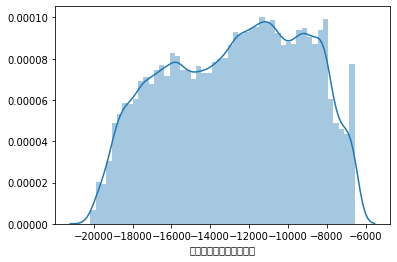

' boxcox '

0.5118304262609339

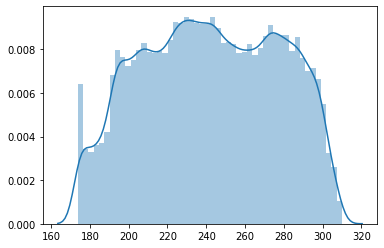

In [246]:
''' ori '''
sns.distplot(X[feat] + 1)
plt.show()

''' boxcox '''
inp = X[feat].apply('abs') + 1
l, opt_lmbda = spstats.boxcox(inp)
opt_lmbda
lmbda = 0
if opt_lmbda > 0:
    lmbda = opt_lmbda
sns.distplot(spstats.boxcox(inp, lmbda=lmbda))
plt.show()

In [ ]:
############## Fill Null

# Fill Null
imp =Imputer(missing_values=np.NaN, strategy="mean", axis=0)
data = imp.fit_transform(data_ori)
len(data)
len(data[0])

In [ ]:
############## X, y

''' y '''
y = data[:, 1]
len(y)
y[:10]

''' X '''
X = data[:, 2:]
len(X)
len(X[0])
X[0][:10]

pd.DataFrame(y).to_csv('./tmp/1_y.csv')
pd.DataFrame(X).to_csv('./tmp/1_X.csv')

In [ ]:
############## Check X, y

X1 = pd.read_csv('./tmp/1_X.csv', header=0, index_col=0)
X1.shape
X1.head()

y1 = pd.read_csv('./tmp/1_y.csv', header=0, index_col=0)
y1.shape
y1.head()

''' y '''
len(y)
y2 = y1['0'].values
len(y2)
(y == y2).sum()

''' X '''
len(X)
len(X[0])
X2 = X1.values
len(X2)
len(X2[0])
(X == X2).sum(axis=1)
140000 * 329

In [ ]:
n=0
y[n]
y2[n]